In [20]:
import numpy as np
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import snowflake.connector
import os
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL


In [31]:
class NeuralNet(nn.Module):
    def __init__(self, lrate, loss_fn, in_size, out_size):
        """
        Initializes the layers of your neural network.

        @param lrate: learning rate for the model
        @param loss_fn: A loss function defined as follows:
            @param yhat - an (N,out_size) Tensor
            @param y - an (N,) Tensor
            @return l(x,y) an () Tensor that is the mean loss
        @param in_size: input dimension
        @param out_size: output dimension

        For Part 1 the network should have the following architecture (in terms of hidden units):

        in_size -> 32 ->  out_size

        We recommend setting lrate to 0.01 for part 1.

        """
        super(NeuralNet, self).__init__()
        self.loss = loss_fn
        self.learning_rate = lrate

        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        self.dropout = nn.Dropout()

        self.optimizer = optim.SGD(self.parameters(), lr=lrate, weight_decay=0.01)

    def set_parameters(self, params):
        """ Sets the parameters of your network.

        @param params: a list of tensors containing all parameters of the network
        """
        self.parameters = params

    def get_parameters(self):
        """ Gets the parameters of your network.

        @return params: a list of tensors containing all parameters of the network
        """
        return self.parameters()

    def forward(self, x):
        """Performs a forward pass through your neural net (evaluates f(x)).

        @param x: an (N, in_size) Tensor
        @return y: an (N, out_size) Tensor of output from the network
        """
        x = x.reshape(len(x),3,32,32)
        x = F.leaky_relu_(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 16 * 16)
        x = F.leaky_relu_(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return (x)



    def step(self, x,y):
        """
        Performs one gradient step through a batch of data x with labels y.

        @param x: an (N, in_size) Tensor
        @param y: an (N,) Tensor
        @return L: total empirical risk (mean of losses) at this timestep as a float
        """

        self.optimizer.zero_grad()
        output = self.forward(x)
        loss = self.loss(output, y)
        loss.backward()
        self.optimizer.step()

        return loss


def fit(train_set,train_labels,dev_set,n_iter,batch_size=100):
    """ Make NeuralNet object 'net' and use net.step() to train a neural net
    and net(x) to evaluate the neural net.

    @param train_set: an (N, in_size) Tensor
    @param train_labels: an (N,) Tensor
    @param dev_set: an (M,) Tensor
    @param n_iter: an int, the number of iterations of training
    @param batch_size: size of each batch to train on. (default 100)

    This method _must_ work for arbitrary M and N.

    @return losses: array of total loss at the beginning and after each iteration.
            Ensure that len(losses) == n_iter.
    @return yhats: an (M,) NumPy array of binary labels for dev_set
    @return net: a NeuralNet object
    """
    net = NeuralNet(0.07, torch.nn.CrossEntropyLoss(), 3072, 2)

    #processing
    m = torch.mean(train_set)
    s = torch.std(train_set)
    train_set = (train_set - m) / s

    m = torch.mean(dev_set)
    s = torch.std(dev_set)
    dev_set = (dev_set - m) / s


    #training
    losses = []
    epoch_count = 0
    for batch_index in range(0, min(len(train_set)-batch_size, 10000), batch_size):
        epoch_count = epoch_count + 1
        for i in range(min(n_iter, 10)):
            batch = train_set[batch_index:batch_index + batch_size]
            labels = train_labels[batch_index:batch_index + batch_size]
            losses.append(net.step(batch, labels))

    #classification
    scores = net.forward(dev_set)
    labels = []
    for tensor in scores:
        first_score = list(tensor)[0].item()
        second_score = list(tensor)[1].item()
        if first_score > second_score:
            labels.append(0)
        else:
            labels.append(1)

    return losses, labels, net

Epoch 0: 0.4254551827907562
Epoch 1: 0.3288988023996353
Epoch 2: 0.1043419448658824
Epoch 3: 0.0294734095223248
Epoch 4: 0.002859966829419136
Epoch 5: 0.0027702655643224716
Epoch 6: 0.0026768159586936235
Epoch 7: 0.002579338848590851
Epoch 8: 0.0024778081569820642
Epoch 9: 0.002372374990954995
Done


In [17]:
# read from snowflake
USER = os.getenv('USER')
PASSWORD = os.getenv('SNOW_PWD')
ACCOUNT = os.getenv('ACCOUNT')
WAREHOUSE = os.getenv('WAREHOUSE')
DATABASE = os.getenv('DATABASE')
SCHEMA = os.getenv('SCHEMA')
TABLE = os.getenv('TABLE')


url = URL(
    account = ACCOUNT,
    user = USER,
    password = PASSWORD,
    database = DATABASE,
    schema = SCHEMA,
    warehouse = WAREHOUSE
)
engine = create_engine(url)
connection = engine.connect()
query = 'select * from ' + DATABASE + "." + SCHEMA + "." + TABLE
df = pd.read_sql(query, connection)


variable = "score"
y = df[variable]
x = df.drop(columns=[variable])

# clean data
enc = OrdinalEncoder()
x = enc.fit_transform(x)
y = enc.fit_transform(np.array(y).reshape(-1, 1))

# split
train_set, test_set, train_labels, test_labels = train_test_split(x, y, test_size=0.33, random_state=42)

losses, labels, net = fit(train_set,train_labels,test_set,n_iter=100,batch_size=100)

error: 0.148692333


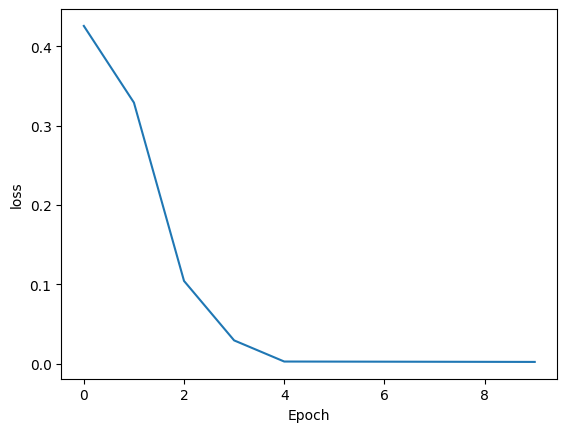

In [30]:
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(losses, [0,1,2,3,4,5,6,7,8,9])

print("error:", np.linalg.norm(test_labels - labels, 2))